In [1]:
import warnings

import numpy as np
import pandas as pd
import quantstats as qs
import yfinance as yf
from IPython.display import clear_output

warnings.filterwarnings('ignore')
pd.options.display.width = 1000

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = list(sp500.Symbol)
sp500_tickers = [e for e in sp500_tickers if e not in ('BRK.B','BF.B')]

# len(sp500_tickers)
# sp500.head(5)

In [3]:
# %%time

data_sp500 = yf.download(sp500_tickers, start='2000-01-01', end='2021-01-01')['Adj Close']

# Filtramos los datos y nos quedamos únicamente con aquellos que tengan más de 1250 datos (5 años)
conteo = pd.DataFrame(data_sp500.count(), columns=['Q'])
sp500_tickers = list(conteo.loc[conteo.Q>1250].index)

pd.options.display.max_columns = 6
# data_sp500.head()

[*********************100%***********************]  503 of 503 completed


In [4]:
# Cantidad de tickers analizados
len(sp500_tickers)

490

In [5]:
w_min, w_max = 0.05, 0.5  
n_stocks = 5

ponds = np.random.dirichlet(np.ones(n_stocks), 100)
oks = [w for w in ponds if (w.min()>w_min) & (w.max()<w_max)]

In [6]:
# TODO GUILLE
# meses = pd.date_range(start='1/1/2000', end='31/12/2020', freq='MS')
# meses_from = list(meses[:-1])
# meses_to = list(meses[1:])
# print(len(meses))
# meses

# dfs_m = []
# rets_log = np.log(data_sp500/data_sp500.shift(1))
# for i in range (len(meses_from)):
#     df = rets_log.loc[(rets_log.index >= meses_from[i]) & (rets_log.index <= meses_to[i])].copy()
#     df.dropna(axis=1, thresh=30, inplace=True)
#     dfs_m.append(df)

In [7]:
trimestres = pd.date_range(start='1/1/2000', end='31/12/2020', freq='Q')
trimestres_from = list(trimestres[:-1])
trimestres_to = list(trimestres[1:])
# print(len(trimestres))
# trimestres

In [8]:
rets_log = np.log(data_sp500/data_sp500.shift(1))

In [9]:
dfs = []
for i in range (len(trimestres_from)):
    df = rets_log.loc[(rets_log.index >= trimestres_from[i]) & (rets_log.index <= trimestres_to[i])].copy()
    df.dropna(axis=1, thresh=30, inplace=True)
    dfs.append(df)

In [10]:
from modulos.funciones import simular

portfolios = simular(rets_log, sp500_tickers, 25000, 5)
print('\n', portfolios.head(10))


100%|██████████| 25000/25000 [01:34<00:00, 263.63it/s]

                              activos                                        weights   retorno  volatilidad  Sharpe Simple
2056    [MKTX, HRL, CMG, PYPL, PAYC]   [0.09836, 0.2681, 0.20986, 0.05507, 0.36861]  0.304019     0.259990        1.16935
12897     [CB, PAYC, VRSK, DVA, HII]    [0.1246, 0.27761, 0.4093, 0.11575, 0.07274]  0.262092     0.228410        1.14747
10214  [PAYC, AIV, AWK, ABBV, GOOGL]  [0.32357, 0.07137, 0.11925, 0.27361, 0.21221]  0.284717     0.249358        1.14180
8631      [PAYC, PPG, HD, DHR, CHTR]  [0.19249, 0.17409, 0.12035, 0.10156, 0.41152]  0.251411     0.224363        1.12056
10967    [MNST, NOW, FLT, LHX, CHRW]   [0.25242, 0.40044, 0.12141, 0.06904, 0.1567]  0.287207     0.260411        1.10290
12936   [VAR, ROST, EXPD, FRC, PAYC]   [0.08783, 0.06527, 0.17045, 0.2526, 0.42385]  0.304027     0.277862        1.09417
16233   [NOW, CHTR, NVDA, MKC, CHRW]   [0.48284, 0.18899, 0.0897, 0.12748, 0.11099]  0.28

In [11]:
top = portfolios.iloc[:100]
lista_tickers = list(top.activos.apply(pd.Series).stack())

freq = pd.DataFrame(np.unique(lista_tickers, return_counts=True)).T
freq.columns=['Ticker','Frecuencia']
freq.sort_values('Frecuencia', ascending=False).head(10)


,Ticker,Frecuencia
169,PAYC,45
159,NOW,16
44,CHTR,11
186,PYPL,9
91,FLT,8
150,MNST,8
61,DG,7
27,AVGO,7
213,TSCO,6
142,MA,6


In [12]:
from modulos.funciones import top10

# %%time
q_inicial = 1000   
lista_tickers = sp500_tickers

portfolios = simular(rets_log, lista_tickers, q_inicial, n_stocks=5, w_min=0.05, w_max=0.50)

best = pd.DataFrame()
for i in range(8): 
    qsim = int(q_inicial/(i+2))   
    qtop = qsim // 3 
    
    top = portfolios.iloc[ : qtop]
    lista_tickers = list(np.array(top.activos.apply(pd.Series).stack()))
    portfolios = simular(rets_log, lista_tickers, qsim)
    best = pd.concat([best,portfolios.iloc[:10]])

print('Mejores\n', best.sort_values('Sharpe Simple', ascending=False).head(10))

100%|██████████| 111/111 [00:00<00:00, 282.76it/s]
Mejores
                            activos                                        weights   retorno  volatilidad  Sharpe Simple
98   [AWK, AVGO, MNST, CHTR, PAYC]  [0.28301, 0.07436, 0.16238, 0.20909, 0.27117]  0.318006     0.232309        1.36889
50     [CDW, DG, PAYC, PYPL, CHTR]  [0.11537, 0.20091, 0.20219, 0.05236, 0.42918]  0.301265     0.221590        1.35956
22      [CHTR, AWK, DG, PAYC, WST]   [0.28865, 0.19935, 0.10475, 0.2215, 0.18575]  0.278355     0.205706        1.35317
109    [PAYC, PAYC, CHTR, DG, CDW]   [0.15279, 0.05284, 0.19406, 0.38921, 0.2111]  0.288289     0.213416        1.35083
47     [CHTR, MNST, DG, CDW, PAYC]  [0.11322, 0.25689, 0.20785, 0.18074, 0.24129]  0.325405     0.240964        1.35043
88     [CHTR, PAYC, ODFL, CDW, DG]  [0.23453, 0.17632, 0.16071, 0.07842, 0.35001]  0.281893     0.209412        1.34612
80   [AVGO, CHTR, PAYC, CDW, MNST]  [0.21103, 0.17325, 0.16972, 0.28396, 0.16203]  0.325286     0.24

In [13]:
%%time 

tops = []
for i, df in enumerate(dfs):
    clear_output(wait=True)
    print('Proceso N°',i+1,'de',len(dfs))
    print('Desde',trimestres_from[i],'Hasta',trimestres_to[i],'\n')
    top = top10(df, list(df.columns), q_inicial=500, rondas=5)
    tops.append(top.iloc[:10]) 

Proceso N° 83 de 83
Desde 2020-09-30 00:00:00 Hasta 2020-12-31 00:00:00 

100%|██████████| 83/83 [00:00<00:00, 358.06it/s]
Wall time: 4min 52s


In [14]:
activos, weights = [], []
for i in range(10):
    activos.append([df.iloc[i].activos for df in tops])
    weights.append([df.iloc[i].weights for df in tops])

In [15]:
resumen = pd.DataFrame() 
pd.options.display.max_columns=10
for top_nro in range(10):
    lista_rendimientos = []
    for i in range(1,len(dfs)):
        filtro_fecha = data_sp500.loc[(data_sp500.index >= trimestres_from[i]) & (data_sp500.index <= trimestres_to[i])]
        filtro_activos = filtro_fecha[activos[top_nro][i-1]].dropna()
        r = filtro_activos.pct_change()
        w = weights[top_nro][i-1]
        fechas = pd.to_datetime(filtro_activos.index)
        lista_rendimientos.append(pd.Series(np.dot(r, w), index=fechas).dropna())

    rendimientos = pd.concat(lista_rendimientos)
    resumen['Test_'+str(top_nro)] = (rendimientos+1).cumprod()

resumen

,Test_0,Test_1,Test_2,Test_3,Test_4,Test_5,Test_6,Test_7,Test_8,Test_9
Date,,,,,,,,,,
2000-07-03,1.011255,0.994829,0.996576,1.004213,1.001582,1.005856,1.017756,0.989758,1.003637,0.998744
2000-07-05,1.016070,0.999779,0.998084,1.012607,1.017450,1.006671,1.010659,0.983552,1.015727,0.996156
2000-07-06,1.031163,1.017673,0.991153,1.030660,1.015511,1.011199,1.034029,0.984908,1.043632,0.994029
2000-07-07,1.029329,1.021677,1.000603,1.032887,1.010201,1.006654,1.038852,0.998819,1.047855,0.993780
2000-07-10,1.032452,1.031387,1.012349,1.037833,1.015806,1.004531,1.038266,1.015958,1.067444,1.002393
...,...,...,...,...,...,...,...,...,...,...
2020-12-07,45.444950,55.114934,99.913529,54.957522,84.668698,36.479345,60.476360,63.595576,134.424141,113.717152
2020-12-08,45.601389,55.110952,100.183654,55.214471,84.959944,36.658855,60.877344,63.676863,134.854151,113.229162
2020-12-09,45.536022,55.084428,99.359490,55.226862,84.697114,36.465323,60.554723,64.130315,133.789972,113.189390


In [16]:
inicio = list(resumen.index)[0].isoformat()[:10]
inicio
spy = yf.download('SPY', start=inicio, auto_adjust=True)
spy['pctChange'] = spy.Close.pct_change()
spy['rendimiento_acum'] = (spy.pctChange+1).cumprod()

[*********************100%***********************]  1 of 1 completed


[]

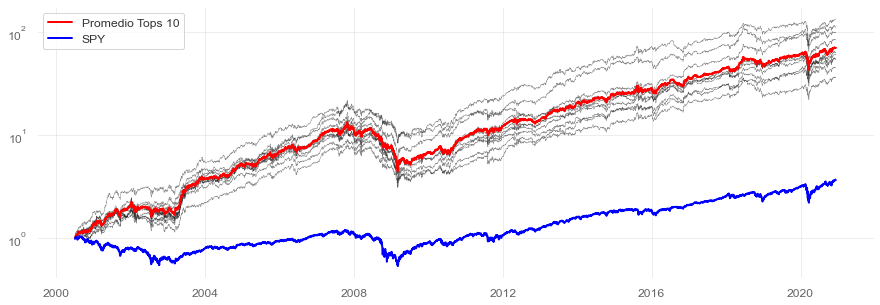

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))

for columna in resumen.columns:
    ax.plot(resumen[columna], 'k', alpha=0.5, lw=0.5)
    ax.set_yscale('log')

ax.plot(resumen.iloc[:,:-1].mean(axis=1), 'red', lw=2, label='Promedio Tops 10')
ax.plot(spy['rendimiento_acum'], 'blue', lw=2, label='SPY')

ax.legend()
ax.plot()

In [18]:
estrategia = resumen.iloc[:,:-1].mean(axis=1) 
estrategia

Date
2000-07-03     1.002829
2000-07-05     1.006733
2000-07-06     1.017770
2000-07-07     1.020764
2000-07-10     1.028447
                ...    
2020-12-07    70.563895
2020-12-08    70.793069
2020-12-09    70.538250
2020-12-10    69.996607
2020-12-11    70.294196
Length: 5118, dtype: float64

In [19]:
qs.extend_pandas()
pd.options.display.max_columns=13
qs.stats.monthly_returns(estrategia)

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,EOY
2000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090249,0.035648,0.054524,-0.020683,-0.007646,0.179097,0.320620
2001,0.076420,-0.022950,-0.039838,0.100938,0.095722,0.028504,0.064015,-0.019386,0.017573,0.036049,0.018900,0.073907,0.432934
2002,-0.008376,-0.120033,0.075993,0.026675,0.007386,-0.020535,-0.087606,0.066381,-0.028760,0.014416,-0.065094,0.016322,-0.105483
2003,0.069403,-0.070448,0.077978,0.167848,0.259889,0.095978,0.053735,0.007543,-0.015147,0.118658,0.082316,-0.034431,0.781901
2004,-0.000654,0.032850,0.016404,-0.040292,0.064028,0.044039,-0.030938,0.000830,0.110844,0.041111,0.079490,0.028948,0.343690
2005,-0.022665,0.017958,-0.014477,-0.010301,0.036874,0.094403,0.052042,0.022521,0.076396,-0.078168,0.017657,0.084089,0.278386
2006,0.050727,0.043597,0.045724,0.001698,-0.042604,0.014842,-0.004561,0.004882,0.013654,0.031262,0.099614,0.010427,0.273123
2007,0.068285,0.077495,0.037014,0.021132,0.055381,-0.033659,-0.007736,-0.002450,0.076049,0.091188,-0.078979,-0.028632,0.283913
2008,-0.088582,0.001924,0.003744,0.065142,0.021455,-0.035865,-0.070018,-0.017530,-0.099347,-0.095456,-0.010931,-0.032950,-0.317130
2009,-0.182663,-0.197517,0.084427,0.058077,-0.088925,-0.001321,0.089438,0.013547,0.059165,-0.054030,0.073059,0.063173,-0.089925


In [20]:
estrategia = resumen.iloc[:,:-1].mean(axis=1) 
benchmark = spy['rendimiento_acum']
qs.reports.metrics(estrategia, benchmark, mode='full')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2000-07-03  2000-07-03
End Period                 2020-12-11  2020-12-11
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          6,909.59%   271.90%
CAGR%                      23.09%      6.63%
Sharpe                     1.04        0.43
Sortino                    1.51        0.6
Max Drawdown               -66.57%     -55.19%
Longest DD Days            1578        2241
Volatility (ann.)          22.52%      19.78%
R^2                        0.47        0.47
Calmar                     0.35        0.12
Skew                       -0.11       -0.03
Kurtosis                   6.21        12.79

Expected Daily %           0.08%       0.03%
Expected Monthly %         1.74%       0.54%
Expected Yearly %          22.43%      6.45%
Kelly Criterion            7.27%       0.52%
Risk of Ruin               0.0%   

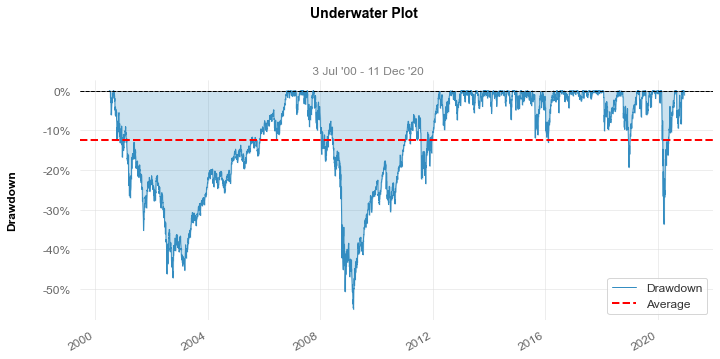

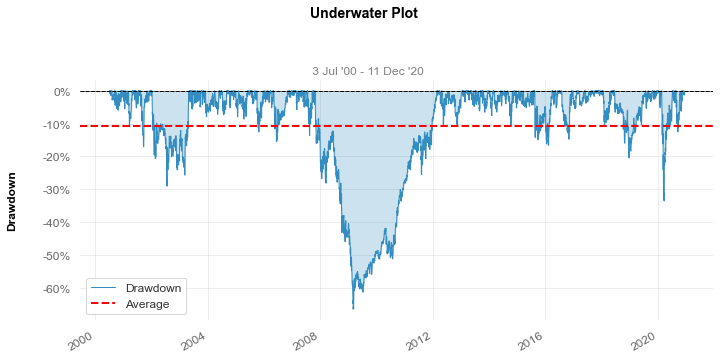

In [21]:
qs.plots.drawdown(benchmark)
qs.plots.drawdown(estrategia)

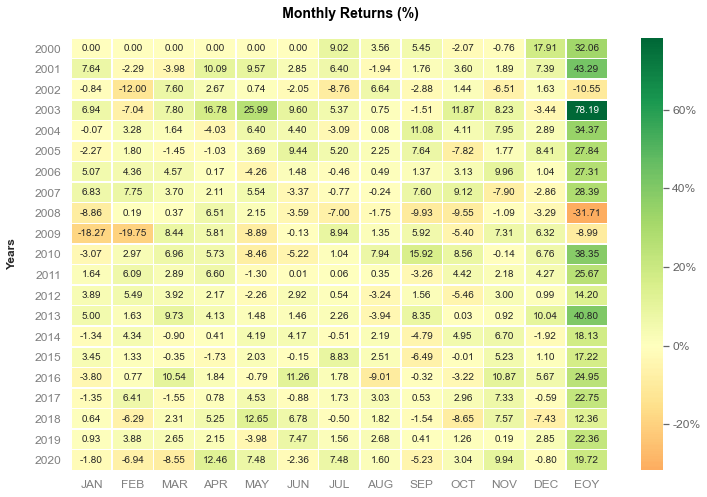

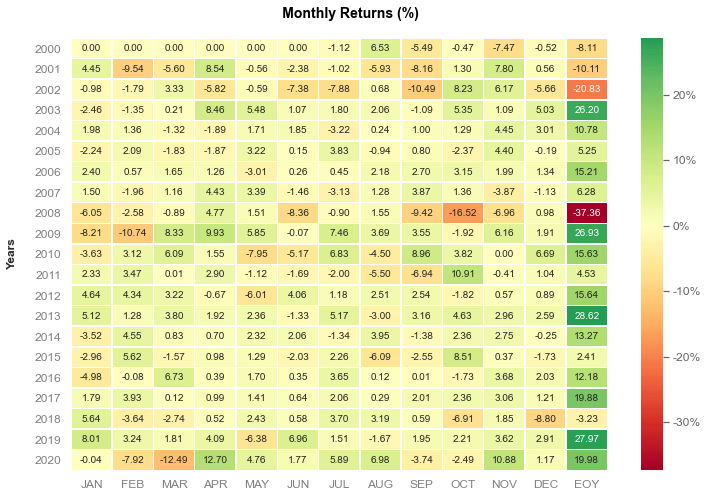

In [22]:
qs.plots.monthly_returns(estrategia, eoy=True)
qs.plots.monthly_returns(benchmark, eoy=True)

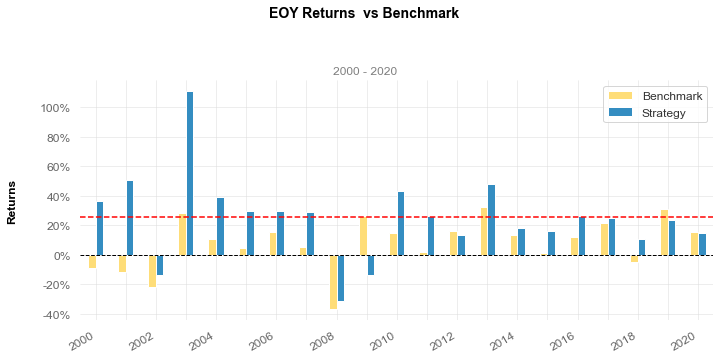

In [23]:
qs.plots.yearly_returns(estrategia, benchmark)

In [24]:
RiskFree = pd.DataFrame(index=estrategia.index)
RiskFree = 0.0001 
EstrategiaPareto = estrategia.pct_change()*0.2 + RiskFree*0.8

EstrategiaPareto

Date
2000-07-03         NaN
2000-07-05    0.000859
2000-07-06    0.002273
2000-07-07    0.000668
2000-07-10    0.001585
                ...   
2020-12-07    0.000587
2020-12-08    0.000730
2020-12-09   -0.000640
2020-12-10   -0.001456
2020-12-11    0.000930
Length: 5118, dtype: float64

In [25]:
qs.reports.metrics(EstrategiaPareto, benchmark, mode='full')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2000-07-03  2000-07-03
End Period                 2020-12-11  2020-12-11
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          282.68%     271.9%
CAGR%                      6.78%       6.63%
Sharpe                     1.49        0.43
Sortino                    2.2         0.6
Max Drawdown               -16.26%     -55.19%
Longest DD Days            1080        2241
Volatility (ann.)          4.5%        19.78%
R^2                        0.47        0.47
Calmar                     0.42        0.12
Skew                       -0.11       -0.03
Kurtosis                   6.21        12.79

Expected Daily %           0.03%       0.03%
Expected Monthly %         0.55%       0.54%
Expected Yearly %          6.6%        6.45%
Kelly Criterion            12.0%       -1.2%
Risk of Ruin               0.0%    

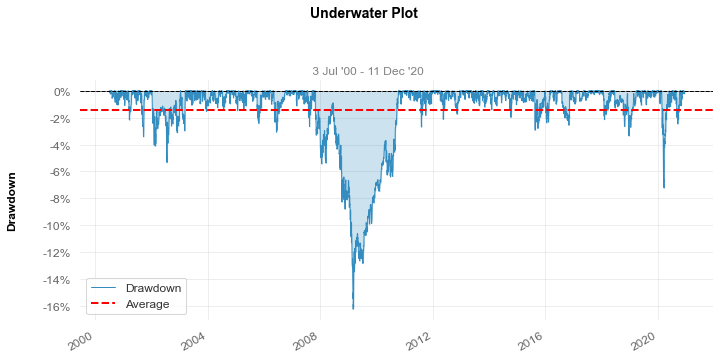

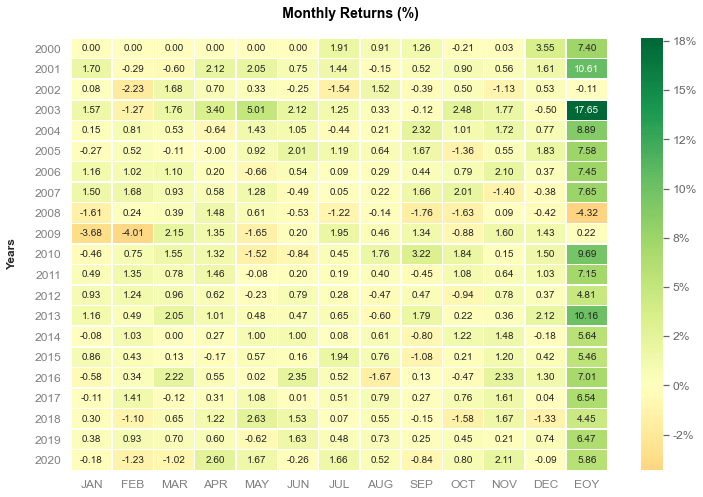

In [26]:
qs.plots.drawdown(EstrategiaPareto)
qs.plots.monthly_returns(EstrategiaPareto, eoy=True)

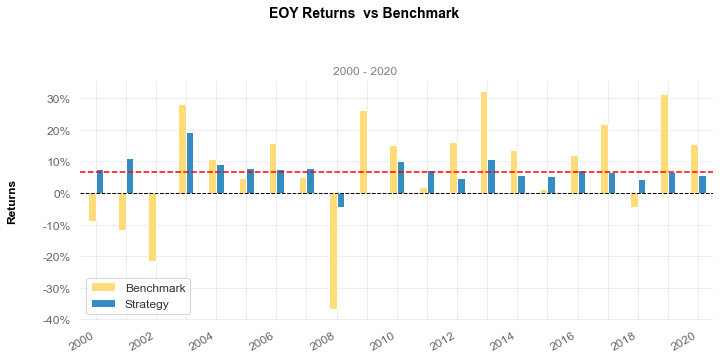

In [27]:
qs.plots.yearly_returns(EstrategiaPareto, benchmark)

                           Strategy
-------------------------  ----------
Start Period               2000-07-03
End Period                 2020-12-11
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          282.68%
CAGR%                      6.78%
Sharpe                     1.49
Sortino                    2.2
Max Drawdown               -16.26%
Longest DD Days            1080
Volatility (ann.)          4.5%
Calmar                     0.42
Skew                       -0.11
Kurtosis                   6.21

Expected Daily %           0.03%
Expected Monthly %         0.55%
Expected Yearly %          6.6%
Kelly Criterion            13.46%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.44%
Expected Shortfall (cVaR)  -0.44%

Payoff Ratio               0.99
Profit Factor              1.31
Common Sense Ratio         1.34
CPC Index                  0.74
Tail Ratio                 1.02
Outlier Win Ratio          3.97
Outlier Loss Ratio         3.9

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-10-30,2009-03-05,2010-10-14,1080,-16.255371,-14.030078
2,2020-02-20,2020-03-23,2020-05-29,99,-7.221048,-6.911854
3,2002-01-10,2002-07-23,2003-01-14,369,-5.332420,-4.388174
4,2001-08-14,2001-09-21,2001-10-16,63,-3.412993,-2.887320
5,2018-06-21,2018-12-24,2019-03-28,280,-3.347082,-2.702974


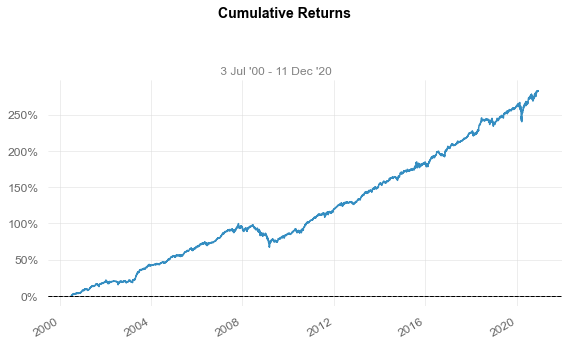

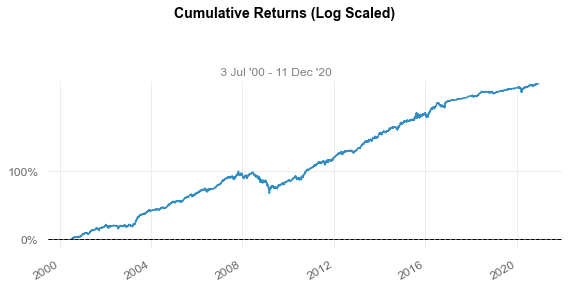

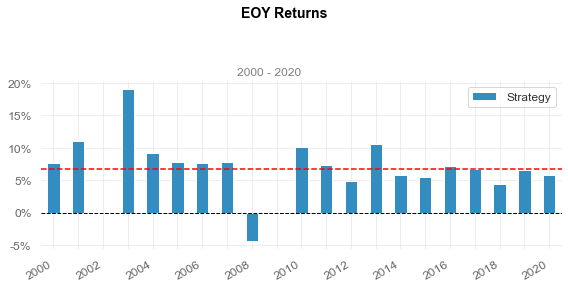

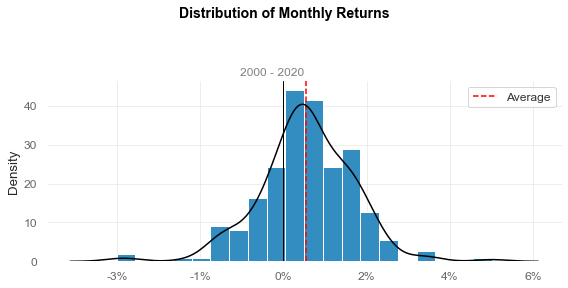

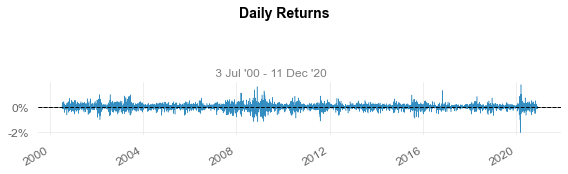

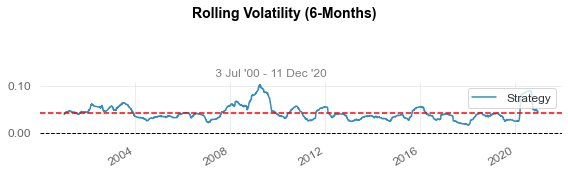

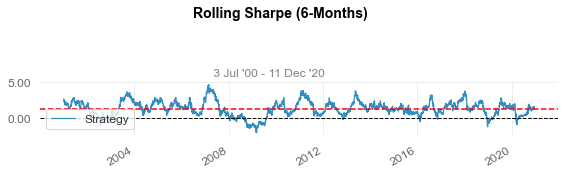

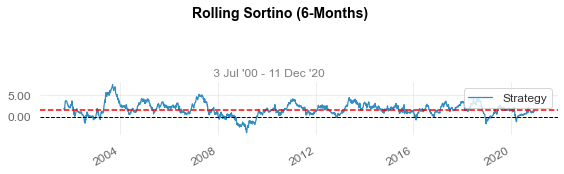

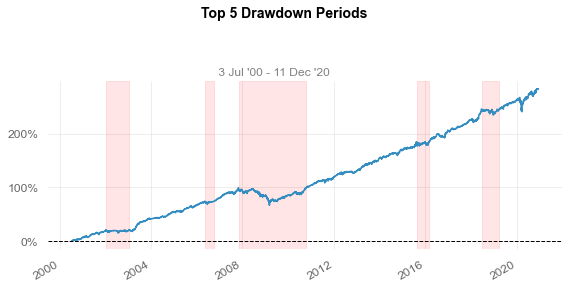

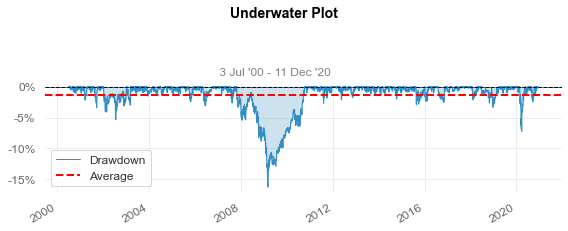

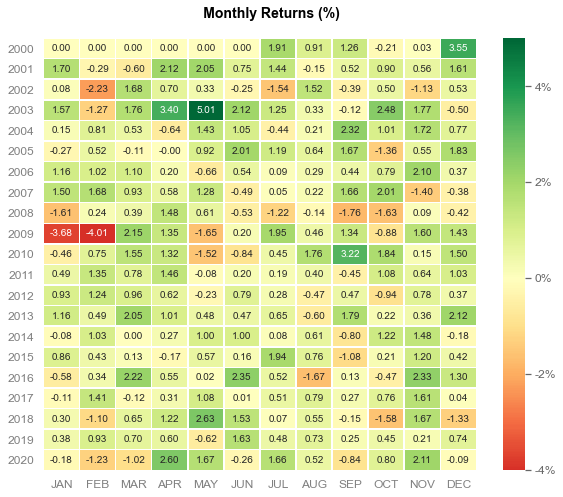

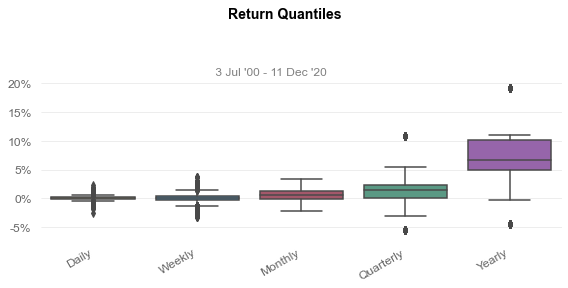

In [28]:
qs.reports.full(EstrategiaPareto)